In [55]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame


start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)

df = web.DataReader("FNF", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-06,24.909748,24.620939,24.823105,24.866426,928200.0,22.950779
2017-01-09,24.895308,24.447653,24.880867,24.685921,1452300.0,22.784178
2017-01-10,24.700361,24.498196,24.649820,24.577618,2209200.0,22.684217
2017-01-11,24.649820,24.418772,24.649820,24.613718,1382900.0,22.717539
2017-01-12,24.584837,24.209387,24.584837,24.382671,1715000.0,22.504288


### Moving Average

In [56]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

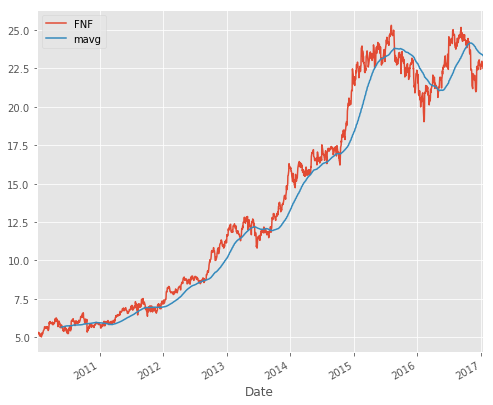

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='FNF')
mavg.plot(label='mavg')
plt.legend()

### Risk/Return

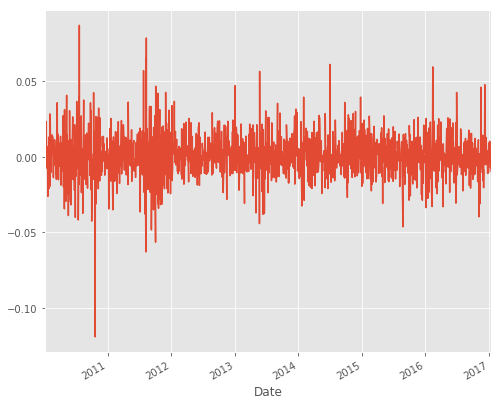

In [60]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

## Predict

In [61]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [62]:
import math
import numpy as np
import sklearn.preprocessing as preprocessing

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]
y_lately = y[-forecast_out:]

## Model Generation

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [64]:
X_train = X
X_test = X_lately
y_train = y
y_test = y_lately

### Linear Regression

In [65]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

### KNN

In [66]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=8)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=8, p=2,
          weights='uniform')

#### Evaluation

In [71]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

# results
print('The linear regression confidence is ', confidencereg)
print('The quadratic regression 2 confidence is ', confidencepoly2)
print('The quadratic regression 3 confidence is ', confidencepoly3)
print('The knn regression confidence is ', confidenceknn)

The linear regression confidence is  0.39944839302554025
The quadratic regression 2 confidence is  0.7957808566164652
The quadratic regression 3 confidence is  0.8221663410284579
The knn regression confidence is  -5.326782751011444


In [77]:
clf = clfpoly3

dfreg['Forecast'] = np.nan
forecast_set = clf.predict(X_lately)

print(forecast_set)

[22.95701893 22.88445407 22.93719571 22.99975703 22.96056855 22.80516369
 22.80559561 22.64302225 22.54897022 22.68456556 22.72782903 22.87102938
 22.93924863 22.93361371 22.87569258 22.73076867 22.75082538 22.64087433]


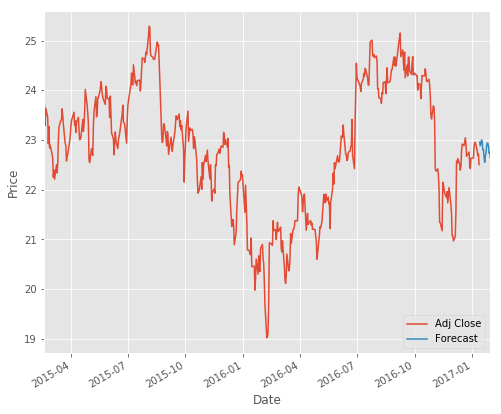

In [78]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()